## Implementing the loss function from data augmentations

In [1]:
import torch
import numpy as np
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets
import os

class SimCLRWrapper(Dataset):
    """Minimal wrapper to create positive pairs."""
    def __init__(self, dataset):
        self.dataset = dataset
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        # Get image twice with different augmentations
        x_i, label = self.dataset[idx]
        x_j, _ = self.dataset[idx]
        return x_i, x_j, label
    

def simclr_collate(batch):
    """Collate function for SimCLR pairs - returns numpy arrays in BHWC format"""
    x_i = torch.stack([item[0] for item in batch]).numpy()  # (B, C, H, W)
    x_j = torch.stack([item[1] for item in batch]).numpy()  # (B, C, H, W)
    
    # Transpose from (B, C, H, W) to (B, H, W, C)
    x_i = np.ascontiguousarray(np.transpose(x_i, (0, 2, 3, 1)))  # (B, H, W, C)
    x_j = np.ascontiguousarray(np.transpose(x_j, (0, 2, 3, 1)))  # (B, H, W, C)
    
    labels = np.array([item[2] for item in batch])
    
    return x_i, x_j, labels


def numpy_collate(batch):
    """Collate function to convert batch to numpy arrays in BHWC format"""
    images, labels = zip(*batch)
    images = torch.stack(images).numpy()  # (B, C, H, W)
    images = np.ascontiguousarray(np.transpose(images, (0, 2, 3, 1)))  # (B, H, W, C)
    labels = np.array(labels)
    return images, labels


def build_dataset(
    dataset_name,
    data_dir,
    batch_size=32,
    is_train=True,
    num_workers=4,
    simclr=False  # ADD THIS PARAMETER
):
    dataset_name = dataset_name.upper()
    
    # Determine image size based on dataset
    if dataset_name in ['CIFAR10', 'CIFAR', 'CIFAR100']:
        image_size = 32  # CIFAR is 32x32
    elif dataset_name in ['IMAGENET', 'IMNET']:
        image_size = 224  # Standard ImageNet size
    else:
        raise ValueError(f"Unknown dataset: {dataset_name}")
    
    # Build transforms
    if is_train:
        if simclr:
            # SimCLR augmentations from the paper
            color_jitter = transforms.ColorJitter(0.7, 0.7, 0.7, 0.2)
            transform = transforms.Compose([
                transforms.RandomResizedCrop(image_size, scale=(0.08, 1.0)),
                transforms.RandomHorizontalFlip(),
                transforms.RandomApply([color_jitter], p=0.8),
                transforms.RandomGrayscale(p=0.2),
                transforms.ToTensor(),
            ])
        else:
            # Your original transforms
            transform = transforms.Compose([
                transforms.RandomResizedCrop(image_size),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
            ])
    else:
        transform = transforms.Compose([
            transforms.Resize(int(image_size * 1.14)),
            transforms.CenterCrop(image_size),
            transforms.ToTensor(),
        ])
    
    # Create dataset
    if dataset_name == 'CIFAR10':
        dataset = datasets.CIFAR10(data_dir, train=is_train, transform=transform, download=True)
        num_classes = 10
    elif dataset_name in ['CIFAR', 'CIFAR100']:
        dataset = datasets.CIFAR100(data_dir, train=is_train, transform=transform, download=True)
        num_classes = 100
    elif dataset_name in ['IMAGENET', 'IMNET']:
        root = os.path.join(data_dir, 'train' if is_train else 'val')
        dataset = datasets.ImageFolder(root, transform=transform)
        num_classes = 1000
    
    # Wrap dataset for SimCLR if needed
    if simclr and is_train:
        dataset = SimCLRWrapper(dataset)
    
    # Get dataset size
    n_samples = len(dataset)
    
    # Modify collate function for SimCLR
    if simclr and is_train:
        collate_fn = simclr_collate
    else:
        collate_fn = numpy_collate
    
    # Create dataloader
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=is_train,
        num_workers=num_workers,
        pin_memory=True,
        drop_last=is_train,
        collate_fn=collate_fn
    )
    
    return dataloader, num_classes, n_samples, image_size

/Users/anton/source/vae/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


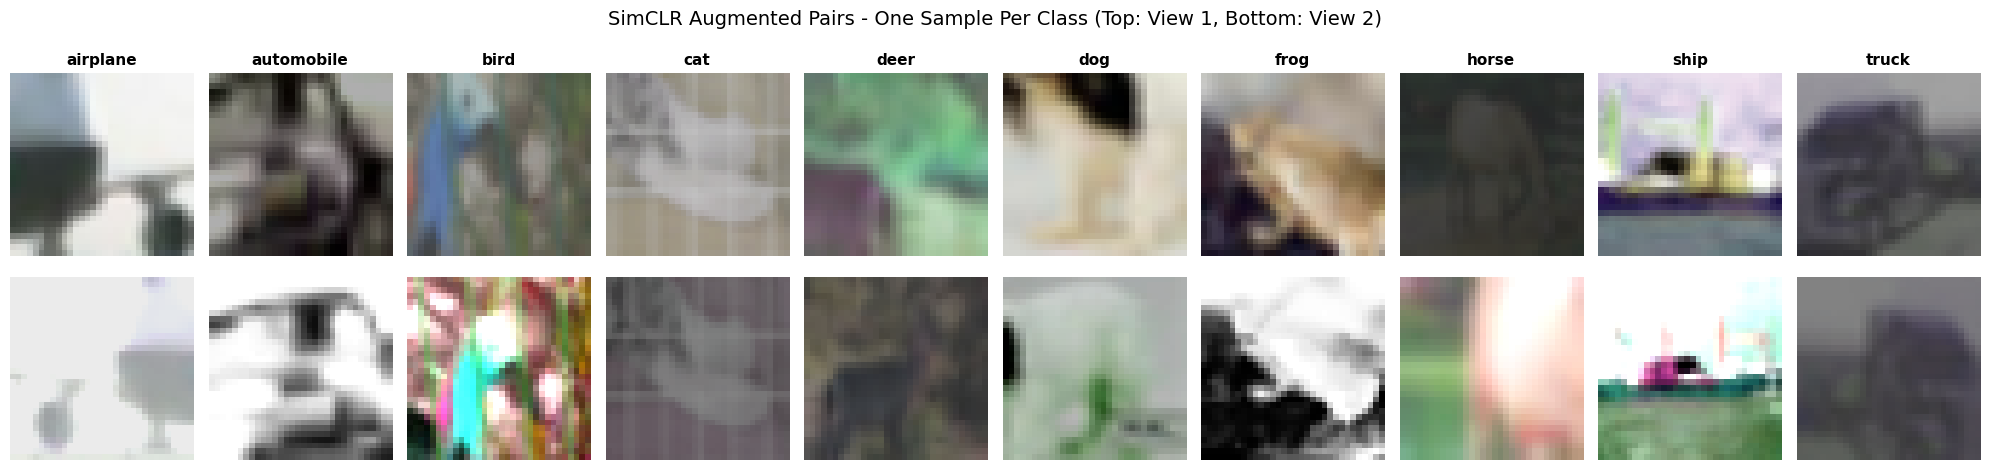

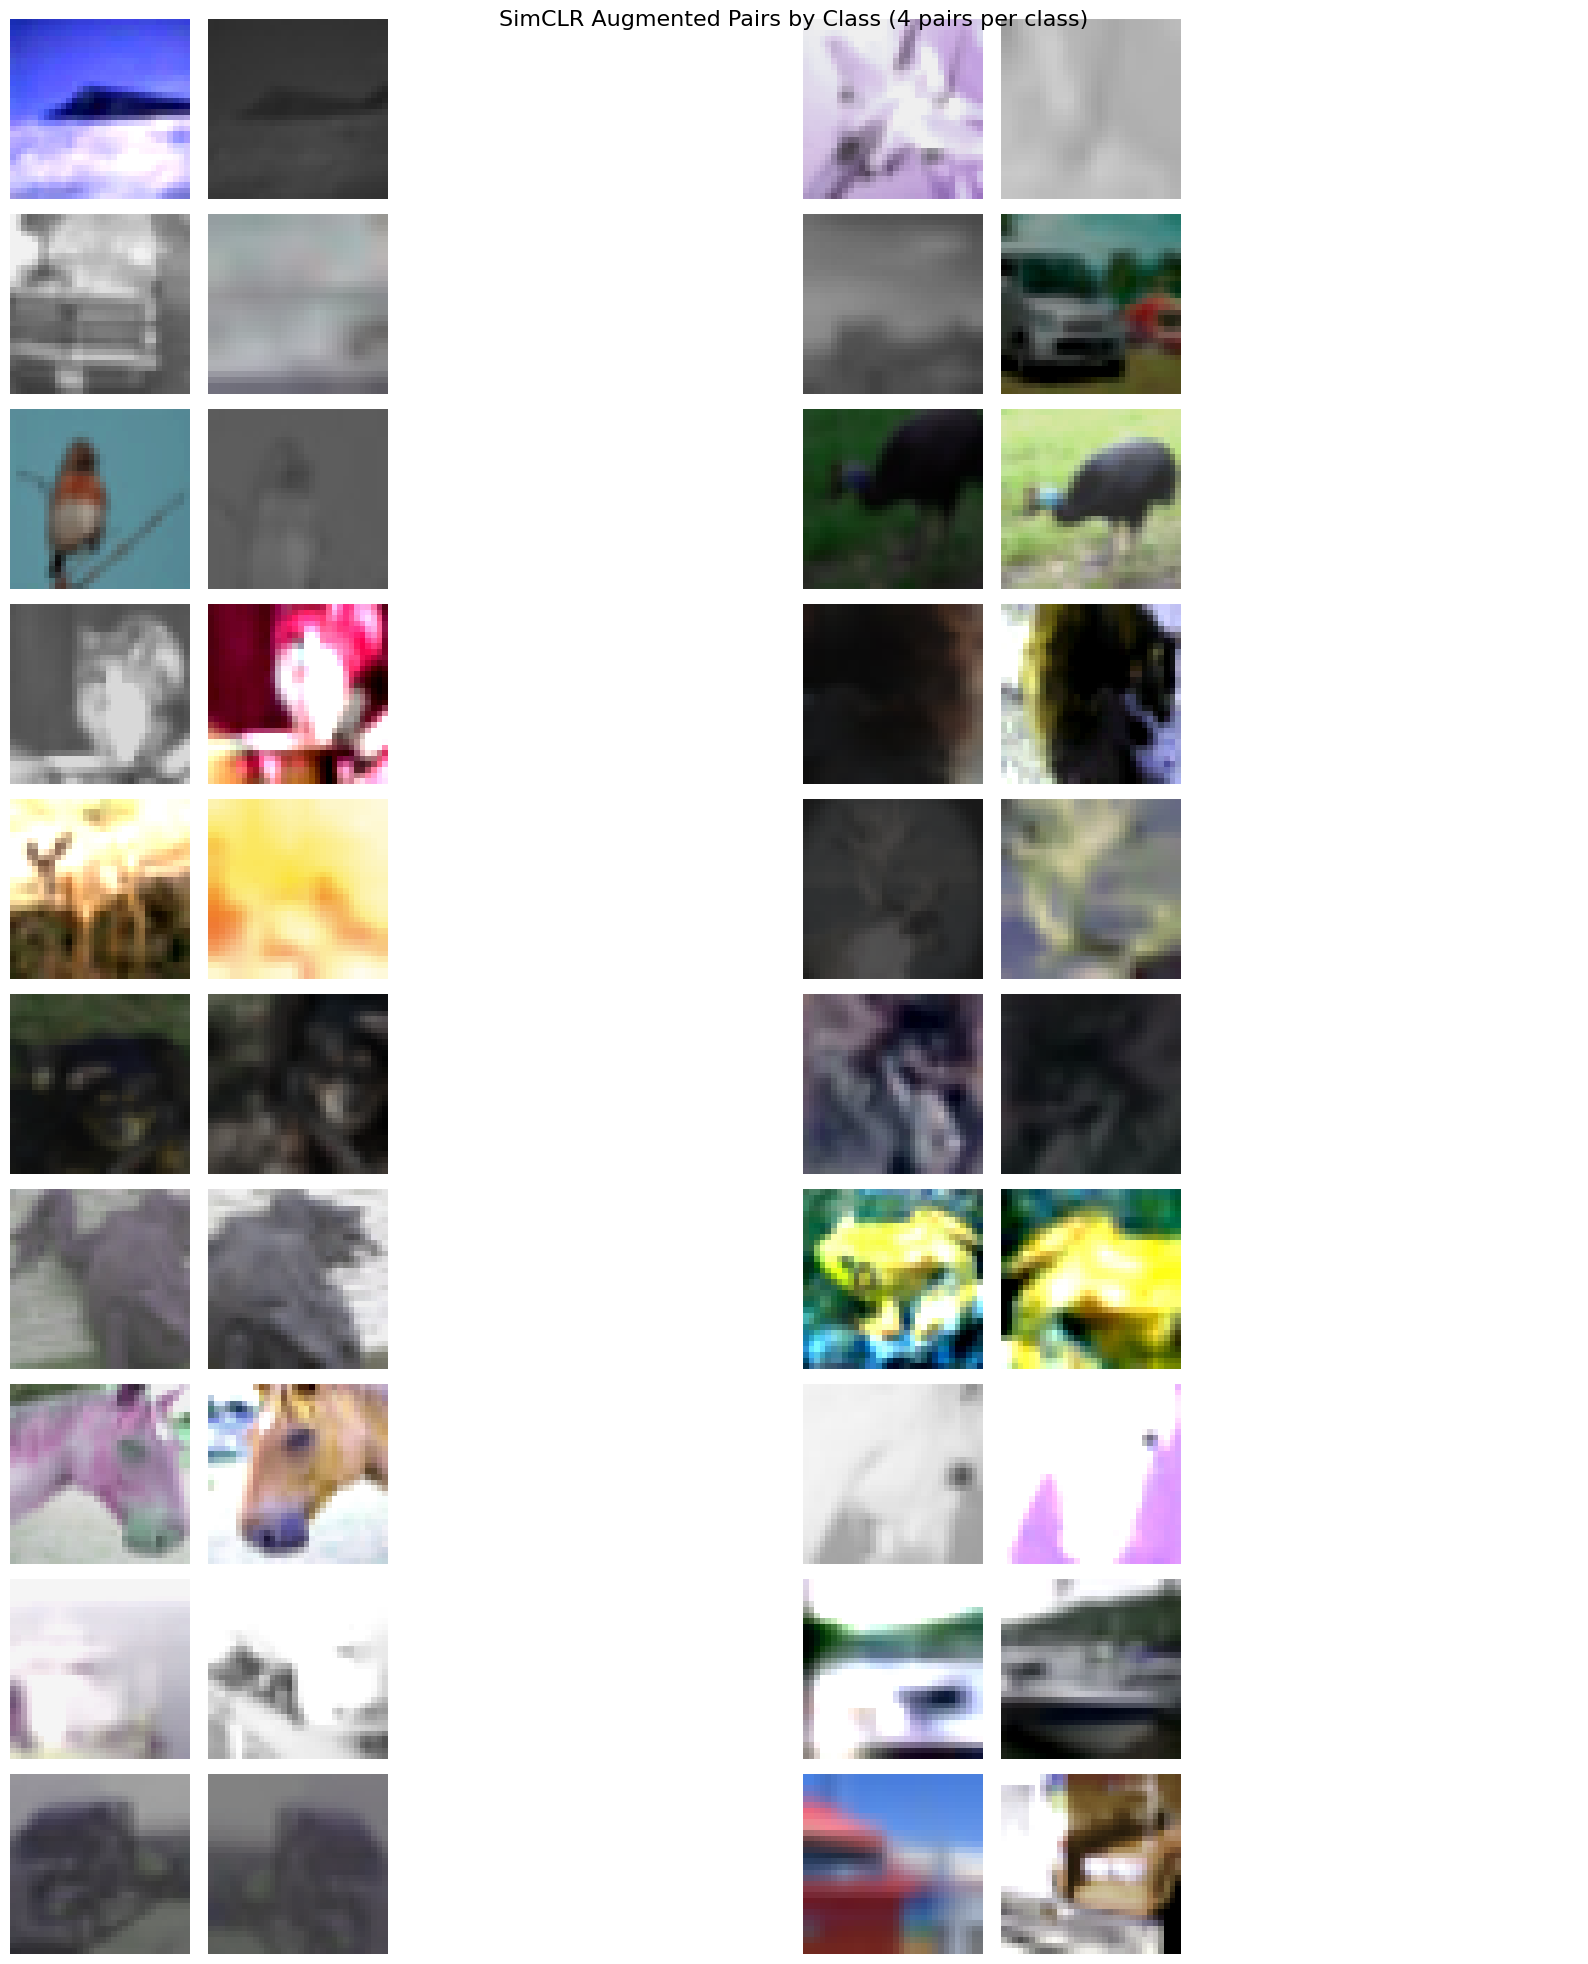

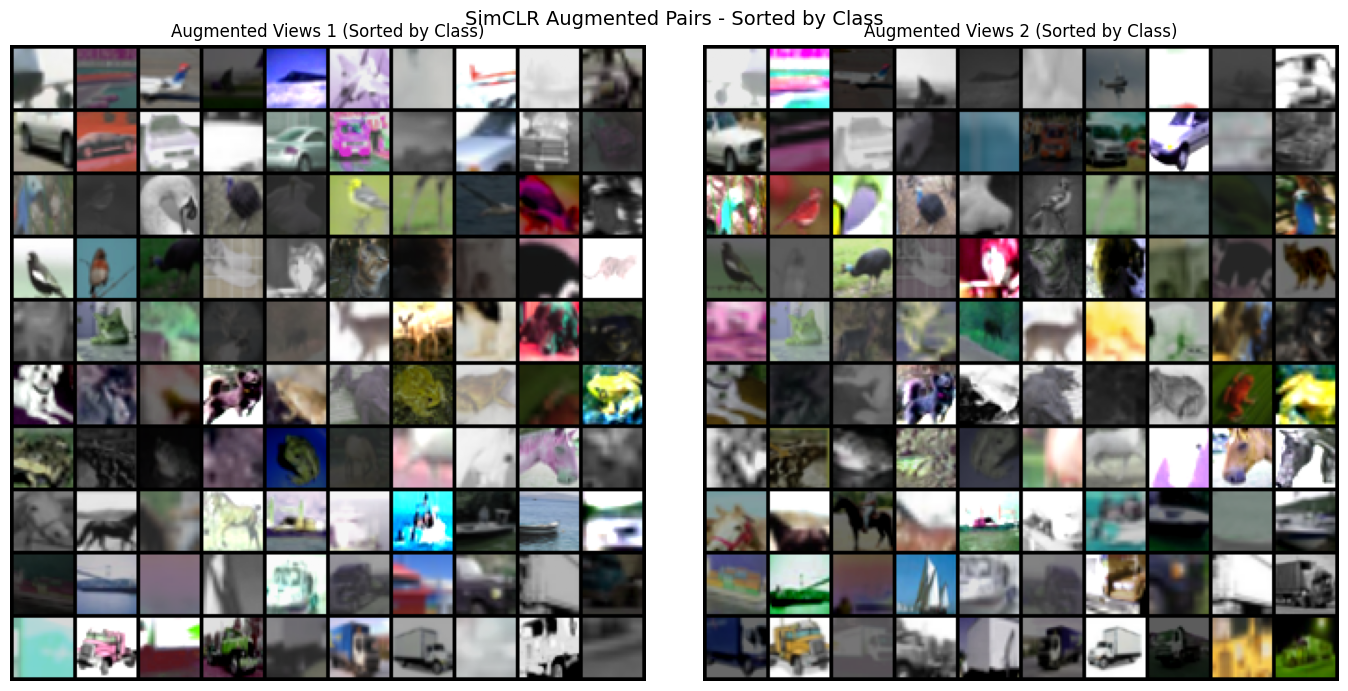

Samples per class in batch:
  airplane    :   9 samples
  automobile  :  11 samples
  bird        :  13 samples
  cat         :   9 samples
  deer        :   5 samples
  dog         :   7 samples
  frog        :  11 samples
  horse       :   9 samples
  ship        :  11 samples
  truck       :  15 samples

Batch statistics:
  Total samples: 100
  Unique classes: 10
  Value ranges: [0.000, 1.000]


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision

# CIFAR10 class names
CIFAR10_CLASSES = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
                   'dog', 'frog', 'horse', 'ship', 'truck']

# Get one batch for visualization
simclr_loader, num_classes, n_samples, image_size = build_dataset(
    dataset_name='CIFAR10',
    data_dir='./data',
    batch_size=100,  # Larger batch to ensure we get all classes
    is_train=True,
    simclr=True,
    num_workers=0
)

# Get first batch - now returns numpy arrays in (B, H, W, C) format
x_i, x_j, labels = next(iter(simclr_loader))

# Sort by labels using numpy
sorted_indices = np.argsort(labels)
x_i_sorted = x_i[sorted_indices]
x_j_sorted = x_j[sorted_indices]
labels_sorted = labels[sorted_indices]

# Number of samples to visualize (one per class)
n_samples_to_show = min(10, len(labels_sorted))

# Create figure for one sample per class
fig, axes = plt.subplots(2, n_samples_to_show, figsize=(20, 5))
fig.suptitle('SimCLR Augmented Pairs - One Sample Per Class (Top: View 1, Bottom: View 2)', fontsize=14)

# Find first occurrence of each class
shown_classes = set()
plot_idx = 0

for idx in range(len(labels_sorted)):
    label = labels_sorted[idx].item() if hasattr(labels_sorted[idx], 'item') else labels_sorted[idx]
    
    if label not in shown_classes and plot_idx < n_samples_to_show:
        shown_classes.add(label)
        
        # First augmented view - already in HWC format
        img_i = x_i_sorted[idx]
        img_i = img_i.clip(0, 1)
        
        # Second augmented view - already in HWC format
        img_j = x_j_sorted[idx]
        img_j = img_j.clip(0, 1)
        
        # Plot first view (top row)
        axes[0, plot_idx].imshow(img_i)
        axes[0, plot_idx].axis('off')
        axes[0, plot_idx].set_title(f'{CIFAR10_CLASSES[label]}', fontsize=11, fontweight='bold')
        
        # Plot second view (bottom row)
        axes[1, plot_idx].imshow(img_j)
        axes[1, plot_idx].axis('off')
        
        plot_idx += 1

plt.tight_layout()
plt.show()

# Alternative: Show multiple samples per class in a grid
fig, axes = plt.subplots(10, 8, figsize=(16, 20))
fig.suptitle('SimCLR Augmented Pairs by Class (4 pairs per class)', fontsize=16)

samples_per_class = 4  # Show 4 samples per class (2 pairs)

for class_idx in range(10):
    # Find samples of this class
    class_mask = labels == class_idx
    class_x_i = x_i[class_mask][:samples_per_class//2]
    class_x_j = x_j[class_mask][:samples_per_class//2]
    
    # Plot samples for this class
    for sample_idx in range(min(samples_per_class//2, len(class_x_i))):
        # First view of pair
        col_idx = sample_idx * 4
        if col_idx < 8:
            img_i = class_x_i[sample_idx].clip(0, 1)
            axes[class_idx, col_idx].imshow(img_i)
            axes[class_idx, col_idx].axis('off')
            if col_idx == 0:
                axes[class_idx, col_idx].set_ylabel(CIFAR10_CLASSES[class_idx], 
                                                    fontsize=10, rotation=0, 
                                                    ha='right', va='center')
            
            # Second view of pair
            img_j = class_x_j[sample_idx].clip(0, 1)
            axes[class_idx, col_idx + 1].imshow(img_j)
            axes[class_idx, col_idx + 1].axis('off')
            
            # Add a small separator
            if col_idx + 2 < 8:
                axes[class_idx, col_idx + 2].axis('off')

# Remove any empty subplots
for i in range(10):
    for j in range(8):
        if not axes[i, j].images:
            axes[i, j].axis('off')

plt.tight_layout()
plt.show()

# Grid view sorted by class
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))

# Take first 100 samples and sort them
n_show = min(100, len(labels))
sorted_indices = np.argsort(labels[:n_show])
x_i_grid = x_i[sorted_indices]
x_j_grid = x_j[sorted_indices]
labels_grid = labels[sorted_indices]

# Convert numpy arrays back to torch tensors for torchvision.utils.make_grid
# Need to transpose from (B, H, W, C) to (B, C, H, W)
x_i_tensor = torch.from_numpy(np.transpose(x_i_grid, (0, 3, 1, 2)))
x_j_tensor = torch.from_numpy(np.transpose(x_j_grid, (0, 3, 1, 2)))

# Create grids
grid_i = torchvision.utils.make_grid(x_i_tensor, nrow=10, normalize=True, padding=2)
ax1.imshow(grid_i.permute(1, 2, 0).cpu())
ax1.set_title('Augmented Views 1 (Sorted by Class)', fontsize=12)
ax1.axis('off')

grid_j = torchvision.utils.make_grid(x_j_tensor, nrow=10, normalize=True, padding=2)
ax2.imshow(grid_j.permute(1, 2, 0).cpu())
ax2.set_title('Augmented Views 2 (Sorted by Class)', fontsize=12)
ax2.axis('off')

plt.suptitle('SimCLR Augmented Pairs - Sorted by Class', fontsize=14)
plt.tight_layout()
plt.show()

# Print statistics by class
print("Samples per class in batch:")
for class_idx, class_name in enumerate(CIFAR10_CLASSES):
    count = (labels == class_idx).sum()
    print(f"  {class_name:12s}: {count:3d} samples")

print(f"\nBatch statistics:")
print(f"  Total samples: {len(labels)}")
print(f"  Unique classes: {len(np.unique(labels))}")
print(f"  Value ranges: [{x_i.min():.3f}, {x_i.max():.3f}]")

In [32]:
x_i, x_j, labels = next(iter(simclr_loader))


In [70]:
import jax
import jax.numpy as jnp 

def norm(x): return jnp.sqrt(jnp.sum((x)**2))
def sqdist(x1, x2): return jnp.sum((x1 - x2)**2)
def cossim(x1, x2): return jnp.sum(x1 * x2) / (norm(x1) * norm(x2))

def _simclr_batch_cat(x_i, x_j):
    x = np.stack([x_i, x_j]).transpose((1, 0, 2, 3, 4))
    shape = x.shape
    x = x.reshape(shape[0] * shape[1], *shape[2:])
    return x

def _sims_mat(x):
    i_grid, j_grid = jnp.meshgrid(jnp.arange(len(x)), jnp.arange(len(x)))
    i_grid, j_grid = i_grid.ravel(), j_grid.ravel()
    x_i, x_j = x[i_grid], x[j_grid]
    s_vec = jax.vmap(cossim)(x_i, x_j)

    return s_vec.reshape(len(x), len(x))

x = _simclr_batch_cat(x_i, x_j)
print(x.shape)
sims = _sims_mat(x)


(200, 32, 32, 3)


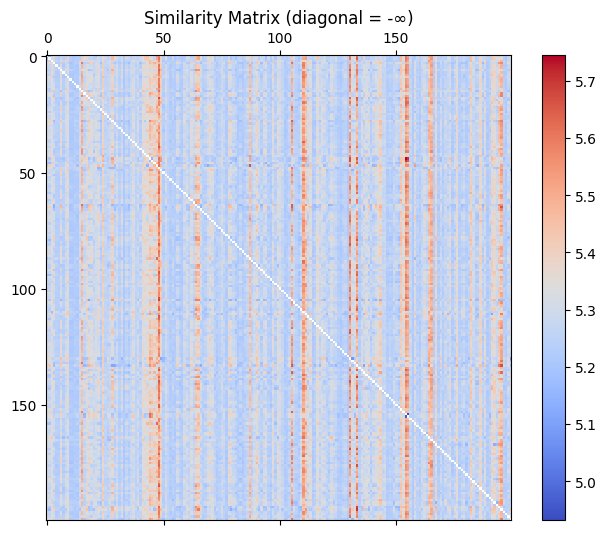

In [ ]:
sims = sims.at[jnp.diag_indices(len(sims))].set(-jnp.inf)
sims = -jnp.log(jax.nn.softmax(sims, axis=1))

# take even / odd pair to get this contrastive loss
loss = 0.5 * jnp.mean(jnp.diag(sims, -1)[::2] + jnp.diag(sims, 1)[::2])

# Plot
plt.figure(figsize=(8, 6))
plt.matshow(sims, fignum=1, cmap='coolwarm')
plt.colorbar()
plt.title('Similarity Matrix (diagonal = -∞)')
plt.show()

In [72]:
loss

Array(5.259766, dtype=float32)

In [103]:

x_i, x_j, labels = next(iter(simclr_loader))

In [108]:
import jax
import jax.numpy as jnp 

def norm(x): return jnp.sqrt(jnp.sum((x)**2))
def sqdist(x1, x2): return jnp.sum((x1 - x2)**2)
def cossim(x1, x2): return jnp.sum(x1 * x2) / (norm(x1) * norm(x2))

B = x_i.shape[0]
D = 32 * 32 * 3

i_grid, j_grid = jnp.meshgrid(jnp.arange(100), jnp.arange(100))
i_grid, j_grid = i_grid.ravel(), j_grid.ravel()
shape = x_i.shape

# can optimize this indexing
def _simclr_batch_cat(x_i, x_j):
    x = jnp.stack([x_i, x_j]).transpose((1, 0, 2, 3, 4))
    x = x.reshape(2 * shape[0], D)
    print(x.shape)
    return x

# need to fix use of grid here
def _sims_mat(x_i, x_j, B=100):
    x_i, x_j = x_i[i_grid], x_j[j_grid]
    s_vec = jax.vmap(cossim)(x_i, x_j)
    print("shape:", s_vec.shape)
    return jnp.reshape(s_vec, (B, B))


@jax.jit
def contrastive_loss(x_i, x_j):
    # x = _simclr_batch_cat(x_i, x_j)
    sims = _sims_mat(x_i, x_j)
    sims = sims.at[jnp.diag_indices(len(sims))].set(-jnp.inf)
    sims = -jnp.log(jax.nn.softmax(sims, axis=0))

    # take even / odd pair to get this contrastive loss
    loss = 0.5 * jnp.mean(jnp.diag(sims, -1)[::2] + jnp.diag(sims, 1)[::2])
    return loss

contrastive_loss(x_i, x_j)

shape: (10000,)


Array(4.59796, dtype=float32)

In [87]:
x_i[i_grid]

IndexError: index 100 is out of bounds for axis 0 with size 100

i_grid (before ravel):
 [[0 1 2 3]
 [0 1 2 3]
 [0 1 2 3]
 [0 1 2 3]]

j_grid (before ravel):
 [[0 0 0 0]
 [1 1 1 1]
 [2 2 2 2]
 [3 3 3 3]]

i_grid raveled: [0 1 2 3 0 1 2 3 0 1 2 3 0 1 2 3]
j_grid raveled: [0 0 0 0 1 1 1 1 2 2 2 2 3 3 3 3]

indexed_i: [10 20 30 40 10 20 30 40 10 20 30 40 10 20 30 40]
indexed_j: [1 1 1 1 2 2 2 2 3 3 3 3 4 4 4 4]

Addition result (as vector): [11 21 31 41 12 22 32 42 13 23 33 43 14 24 34 44]

Matrix after reshape (sim_matrix[i,j] = x_i[i] + x_j[j]):
[[11 21 31 41]
 [12 22 32 42]
 [13 23 33 43]
 [14 24 34 44]]


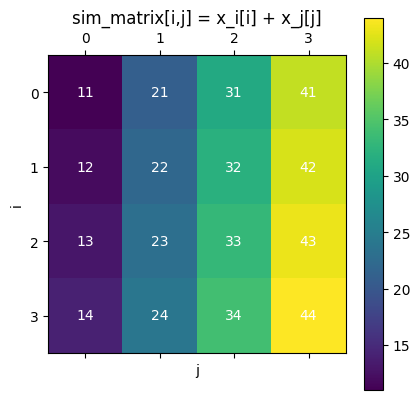


Verification:
[0,0]: 11 == 10+1 = 11 ✓
[0,1]: 21 == 10+2 = 12 ✗
[0,2]: 31 == 10+3 = 13 ✗
[0,3]: 41 == 10+4 = 14 ✗
[1,0]: 12 == 20+1 = 21 ✗
[1,1]: 22 == 20+2 = 22 ✓
[1,2]: 32 == 20+3 = 23 ✗
[1,3]: 42 == 20+4 = 24 ✗
[2,0]: 13 == 30+1 = 31 ✗
[2,1]: 23 == 30+2 = 32 ✗
[2,2]: 33 == 30+3 = 33 ✓
[2,3]: 43 == 30+4 = 34 ✗
[3,0]: 14 == 40+1 = 41 ✗
[3,1]: 24 == 40+2 = 42 ✗
[3,2]: 34 == 40+3 = 43 ✗
[3,3]: 44 == 40+4 = 44 ✓


In [101]:
import jax.numpy as jnp
import matplotlib.pyplot as plt

# Simple test with small arrays
B = 4
x_i = jnp.array([10, 20, 30, 40])
x_j = jnp.array([1, 2, 3, 4])

# Create meshgrid and ravel
i_grid, j_grid = jnp.meshgrid(jnp.arange(B), jnp.arange(B))
print("i_grid (before ravel):\n", i_grid)
print("\nj_grid (before ravel):\n", j_grid)

i_grid, j_grid = i_grid.ravel(), j_grid.ravel()
print("\ni_grid raveled:", i_grid)
print("j_grid raveled:", j_grid)

# Apply indexing and compute
indexed_i = x_i[i_grid]
indexed_j = x_j[j_grid]
print("\nindexed_i:", indexed_i)
print("indexed_j:", indexed_j)

# Addition operation
similarities = indexed_i + indexed_j
print("\nAddition result (as vector):", similarities)

# Reshape to matrix
sim_matrix = similarities.reshape(B, B)
print("\nMatrix after reshape (sim_matrix[i,j] = x_i[i] + x_j[j]):")
print(sim_matrix)

# Visualize
plt.matshow(sim_matrix, cmap='viridis')
plt.colorbar()
for i in range(B):
    for j in range(B):
        plt.text(j, i, f'{int(sim_matrix[i,j])}', ha='center', va='center', color='white')
plt.title('sim_matrix[i,j] = x_i[i] + x_j[j]')
plt.xlabel('j')
plt.ylabel('i')
plt.show()

# Quick verification
print("\nVerification:")
for i in range(B):
    for j in range(B):
        expected = x_i[i] + x_j[j]
        actual = sim_matrix[i, j]
        status = "✓" if actual == expected else "✗"
        print(f"[{i},{j}]: {actual} == {x_i[i]}+{x_j[j]} = {expected} {status}")


In [ ]:
plt.matshow()

(100,)

In [ ]:
# For regular VQVAE training (your current use case)
train_loader, num_classes, n_samples, image_size = build_dataset(
    dataset_name='CIFAR10',
    data_dir='./data',
    batch_size=32,
    is_train=True,
    simclr=False  # Regular mode
)

# For SimCLR training
simclr_loader, num_classes, n_samples, image_size = build_dataset(
    dataset_name='CIFAR10',
    data_dir='./data',
    batch_size=256,  # SimCLR uses larger batches
    is_train=True,
    simclr=True  # SimCLR mode - returns pairs
)

# Training loop for SimCLR
for x_i, x_j, labels in simclr_loader:
    # x_i: [N, C, H, W] - first views
    # x_j: [N, C, H, W] - second views
    
    # Combine for efficient forward pass
    x = torch.cat([x_i, x_j], dim=0)  # [2N, C, H, W]
    
    # Pass through your VQVAE encoder
   #h = vqvae_encoder(x)  # representations
    #z = projection_head(h)  # projections
    
    # Compute SimCLR loss...